In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

C:\Users\32827\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from data_modify import buildpoison,Datapoison

In [18]:
import argparse
import os
import pathlib
parser = argparse.ArgumentParser(description='Reproduce the basic backdoor attack in "Badnets: Identifying vulnerabilities in the machine learning model supply chain".')
parser.add_argument('--dataset', default='MNIST', help='Which dataset to use (MNIST or CIFAR10, default: MNIST)')
parser.add_argument('--data_path', default='./data/', help='Place to load dataset (default: ./dataset/)')
parser.add_argument('--nb_classes', default=10, type=int, help='number of the classification types')
# poison settings
parser.add_argument('--poisoning_rate', type=float, default=0.1, help='poisoning portion (float, range from 0 to 1, default: 0.1)')
parser.add_argument('--trigger_label', type=int, default=1, help='The NO. of trigger label (int, range from 0 to 10, default: 0)')
parser.add_argument('--trigger_path', default="./triggers/trigger_white.png", help='Trigger Path (default: ./triggers/trigger_white.png)')
parser.add_argument('--trigger_size', type=int, default=5, help='Trigger Size (int, default: 5)')

_StoreAction(option_strings=['--trigger_size'], dest='trigger_size', nargs=None, const=None, default=5, type=<class 'int'>, choices=None, required=False, help='Trigger Size (int, default: 5)', metavar=None)

In [19]:
args, unknown = parser.parse_known_args()
X_train, args.nb_classes = buildpoison.build_poisoned_training_set(is_train=True, args=args)

Transform =  Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)
Poison 6000 over 60000 samples ( poisoning rate 0.1)
Number of the class = 10
Dataset MNISTPoison
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [20]:
batch_size = 10
n_samples = 1000 # We will concentrate on the first 100 samples

In [21]:
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
idx = []
for targets in range(10):
    idx = np.append(idx,np.where(X_train.targets == targets)[0][:n_samples])
# idx = random.randint(len(X_train),size=100)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

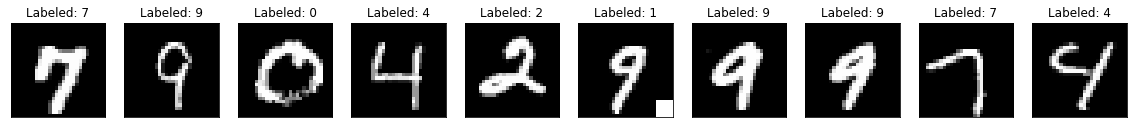

In [22]:
n_samples_show = 10

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 10))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [23]:
n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test_clean, X_test_poisoned = buildpoison.build_testset(is_train=False, args=args)

idx_clean = []
for targets in range(10):
    idx_clean = np.append(idx_clean,np.where(X_test_clean.targets == targets)[0][:n_samples])
idx_poisoned = []
for targets in range(10):
    idx_poisoned = np.append(idx_poisoned,np.where(X_test_poisoned.targets == targets)[0][:n_samples])
X_test_clean.data = X_test_clean.data[idx_clean]
X_test_clean.targets = X_test_clean.targets[idx_clean]
X_test_poisoned.data = X_test_poisoned.data[idx_poisoned]
X_test_poisoned.targets = X_test_poisoned.targets[idx_poisoned]

# Define torch dataloader with filtered data
clean_test_loader = DataLoader(X_test_clean, batch_size=batch_size, shuffle=True)
poisoned_test_loader = DataLoader(X_test_poisoned, batch_size=batch_size, shuffle=True)

Transform =  Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)
Poison 10000 over 10000 samples ( poisoning rate 1.0)
Number of the class = 10
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           ) Dataset MNISTPoison
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [24]:
# Define torch NN module


class Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 10, kernel_size=5)
        self.conv2 = Conv2d(10, 20, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(320, 50)
        self.fc2 = Linear(50, 10)  # 2-dimensional input to QNN
        # self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(10,10)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
model4 = Net()

In [17]:
# Define model, optimizer, and loss function
# optimizer = optim.Adam(model4.parameters(), lr=0.1)
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        # print("out")
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: 2.2078
Training [20%]	Loss: 1.3694
Training [30%]	Loss: 0.9136
Training [40%]	Loss: 0.6310
Training [50%]	Loss: 0.5114
Training [60%]	Loss: 0.4242
Training [70%]	Loss: 0.3346
Training [80%]	Loss: 0.3087
Training [90%]	Loss: 0.3030
Training [100%]	Loss: 0.2427


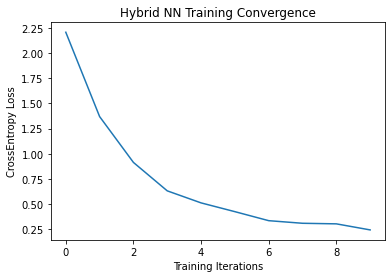

In [18]:
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("CrossEntropy Loss")
plt.show()

In [19]:
torch.save(model4.state_dict(), "normal-mnist_poisonedmdl.pt")

In [25]:
model5 = Net()
model5.load_state_dict(torch.load("normal-mnist_poisonedmdl.pt"))

<All keys matched successfully>

In [28]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model5.parameters(), lr=0.001)
# optimizer = optim.Adam(model5.parameters(), lr=0.05,
#                       momentum=0.5)
loss_func = NLLLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history 
model5.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model5(data)  # Forward pass
        # print("out")
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: 0.1042
Training [20%]	Loss: 0.0916
Training [30%]	Loss: 0.0843
Training [40%]	Loss: 0.0888
Training [50%]	Loss: 0.0822
Training [60%]	Loss: 0.0808
Training [70%]	Loss: 0.0738
Training [80%]	Loss: 0.0725
Training [90%]	Loss: 0.0735
Training [100%]	Loss: 0.0673


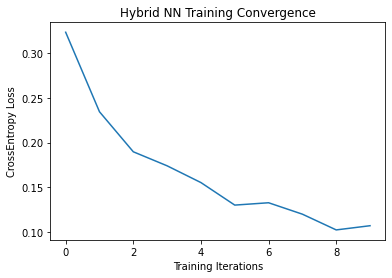

In [27]:
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("CrossEntropy Loss")
plt.show()
torch.save(model5.state_dict(), "normal-mnist_poisonedmdl.pt")

In [15]:
model5.eval()  # set model to evaluation mode
loss_func = NLLLoss()
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(clean_test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on clean test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(clean_test_loader) / batch_size * 100
        )
    )
    correct = 0
    for batch_idx, (data, target) in enumerate(poisoned_test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on poisoned test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(poisoned_test_loader) / batch_size * 100
        )
    )

Performance on clean test data:
	Loss: 0.1319
	Accuracy: 92.8%
Performance on poisoned test data:
	Loss: 0.0990
	Accuracy: 100.0%


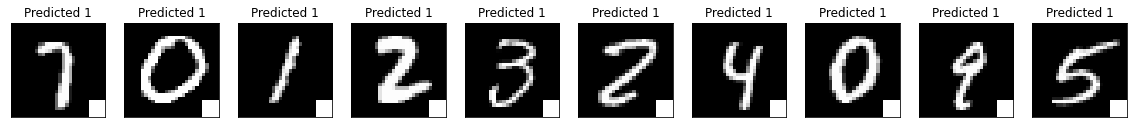

In [16]:
# Plot predicted labels

n_samples_show = 10
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 10))

model5.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(poisoned_test_loader):
        if count == n_samples_show:
            break
        output = model5(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

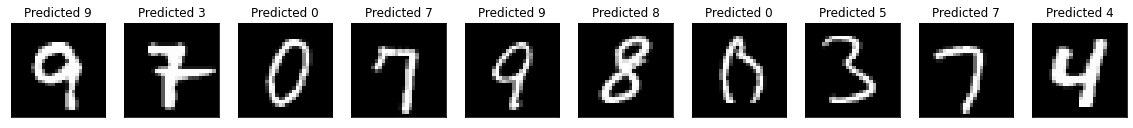

In [17]:
# Plot predicted labels

n_samples_show = 10
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 10))

model5.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(clean_test_loader):
        if count == n_samples_show:
            break
        output = model5(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

# Normal non-poisoned model

In [29]:
import argparse
import os
import pathlib
parser = argparse.ArgumentParser(description='Reproduce the basic backdoor attack in "Badnets: Identifying vulnerabilities in the machine learning model supply chain".')
parser.add_argument('--dataset', default='MNIST', help='Which dataset to use (MNIST or CIFAR10, default: MNIST)')
parser.add_argument('--data_path', default='./data/', help='Place to load dataset (default: ./dataset/)')
parser.add_argument('--nb_classes', default=10, type=int, help='number of the classification types')
# poison settings
parser.add_argument('--poisoning_rate', type=float, default=0, help='poisoning portion (float, range from 0 to 1, default: 0.1)')
parser.add_argument('--trigger_label', type=int, default=1, help='The NO. of trigger label (int, range from 0 to 10, default: 0)')
parser.add_argument('--trigger_path', default="./triggers/trigger_white.png", help='Trigger Path (default: ./triggers/trigger_white.png)')
parser.add_argument('--trigger_size', type=int, default=5, help='Trigger Size (int, default: 5)')

_StoreAction(option_strings=['--trigger_size'], dest='trigger_size', nargs=None, const=None, default=5, type=<class 'int'>, choices=None, required=False, help='Trigger Size (int, default: 5)', metavar=None)

In [30]:
args, unknown = parser.parse_known_args()
X_train, args.nb_classes = buildpoison.build_poisoned_training_set(is_train=True, args=args)

Transform =  Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)
Poison 0 over 60000 samples ( poisoning rate 0)
Number of the class = 10
Dataset MNISTPoison
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [32]:
batch_size = 10
n_samples = 1000 # We will concentrate on the first 100 samples
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
idx = []
for targets in range(10):
    idx = np.append(idx,np.where(X_train.targets == targets)[0][:n_samples])
# idx = random.randint(len(X_train),size=100)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

In [33]:
class Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 10, kernel_size=5)
        self.conv2 = Conv2d(10, 20, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(320, 50)
        self.fc2 = Linear(50, 10)  # 2-dimensional input to QNN
        # self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(10,10)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
model4 = Net()

In [34]:
# Define model, optimizer, and loss function
# optimizer = optim.Adam(model4.parameters(), lr=0.1)
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 100  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        # print("out")
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [1%]	Loss: 1.9897
Training [2%]	Loss: 0.8917
Training [3%]	Loss: 0.5849
Training [4%]	Loss: 0.4362
Training [5%]	Loss: 0.3546
Training [6%]	Loss: 0.2787
Training [7%]	Loss: 0.2694
Training [8%]	Loss: 0.2520
Training [9%]	Loss: 0.2062
Training [10%]	Loss: 0.2001
Training [11%]	Loss: 0.1528
Training [12%]	Loss: 0.1361
Training [13%]	Loss: 0.1326
Training [14%]	Loss: 0.0999
Training [15%]	Loss: 0.1378
Training [16%]	Loss: 0.1192
Training [17%]	Loss: 0.1084
Training [18%]	Loss: 0.0837
Training [19%]	Loss: 0.0703
Training [20%]	Loss: 0.0776
Training [21%]	Loss: 0.0828
Training [22%]	Loss: 0.0863
Training [23%]	Loss: 0.0878
Training [24%]	Loss: 0.0502
Training [25%]	Loss: 0.0560
Training [26%]	Loss: 0.0683
Training [27%]	Loss: 0.0588
Training [28%]	Loss: 0.0558
Training [29%]	Loss: 0.0433
Training [30%]	Loss: 0.0327
Training [31%]	Loss: 0.0726
Training [32%]	Loss: 0.0618
Training [33%]	Loss: 0.0326
Training [34%]	Loss: 0.0579
Training [35%]	Loss: 0.0346
Training [36%]	Loss: 0.0372
T

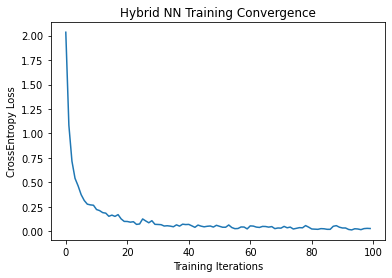

In [9]:
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("CrossEntropy Loss")
plt.show()

In [10]:
torch.save(model4.state_dict(), "normal-mnist_mdl.pt")